# A3-Q2: Golf Driving Range

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
# Supplied functions
def Ground(d):
    '''
     h = Ground(d)
     
     Returns the height (in metres) of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2.*(np.cos(d/4.)-np.sin(d/11.)-1)

def GroundSlope(d):
    '''
     h = GroundSlope(d)
     
     Returns the slope of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2.*(-1./4*np.sin(d/4) - 1./11*np.cos(d/11.))

## (a) MyOde

In [3]:
def MyOde(f, tspan, y0, h, event=(lambda t,y:1)):
    '''
     t,y = MyOde(f, tspan, y0, h, event=[])
    
     Numerically solves the initial value problem
    
        dy(t)/dt = f(t,y)
            y(0) = y0
    
     using the Modified Euler time-stepping method.
    
     Input
       f       a Python dynamics function with calling sequence
                  dydt = f(t, y)
       tspan   2-tuple giving the start and end times, [start, end]
       y0      initial state of the system (as a 1D vector)
       h       the time step to use (this is not adaptive time stepping)
       events  an event function with calling sequence
                  val = events(t, y)
               The computation stops as soon as a negative value is
               returned by the event function.
    
     Output
       t       1D vector holding time stamps
       y       an array that holds one state vector per row (corresponding
               to the time stamps)
    
       Notes:
           - t and y have the same number of rows.
    
           - The first element of t should be tspan[0], and the first
             row of y should be the initial state, y0.
    
           - If the computation was stopped by the triggering of an event,
             then the last row of t and y should correspond to the
             time that linear interpolation indicates for the zero-crossing
             of the event-function.
    '''
    
    # Initialize output arrays, tlst and ylst
    t = tspan[0]
    y = deepcopy(y0)
    
    tlst = []
    ylst = []
    
    tlst.append(t)
    ylst.append(list(y))
    
    
    # === YOUR CODE HERE ===
    
    
    return np.array(tlst), np.array(ylst)


## (b) Dynamics Function: `projectile`

In [4]:
def projectile(t, z):

    dzdt = np.zeros_like(z)
    
    # === YOUR CODE HERE ===
    
    return dzdt

## (c) Events Function: `projectile_events`

In [5]:
def projectile_events(t, z):
    
    val = 1
    
    # === YOUR CODE HERE ===
    
    return val

## (d) Three flights

In [6]:
theta = 50
S = 58
tspan = [0, 30]
h = 0.05
theta_rad = theta/180.*np.pi
yStart = np.array([0, 0, S*np.cos(theta_rad), S*np.sin(theta_rad)])

t,y = MyOde(projectile, tspan, yStart, h, projectile_events)


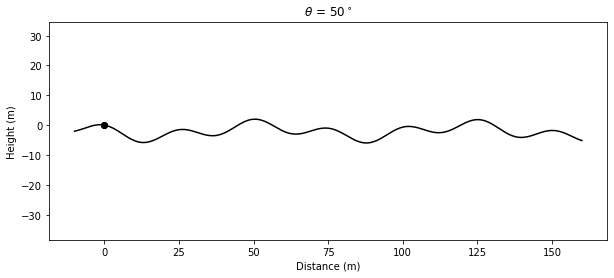

In [7]:
# Plot the ground
x = np.linspace(-10, 160, 300)
hills = Ground(x)
plt.figure(figsize=[10,4])
plt.plot(x,hills, 'k')
plt.axis('equal')

plt.plot(y[:,0], y[:,1])  # Plot ball trajectory
plt.plot([0],[0], 'ko')   # Plot initial ball position
plt.plot(y[-1,0], y[-1,1], 'ko')  # Plot final ball position

plt.title(r'$\theta$ = '+str(theta)+'$^\circ$');
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)');